In [1]:
# Requirements
import pandas as pd
import numpy as np
import networkx as nx

from node2vec import Node2Vec
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

*Required DataFrames*

In [2]:
# Origional Full DataFrame
trans_3w = pd.read_csv('trans_3w.csv')

# Remove OverFlow error created Negative Amounts
trans_3w = trans_3w[trans_3w['ammount'] > 0]

trans_3w.head()

,txn_hash,input_address,output_address,ammount,fees,block_index,block_time,input_flag,output_flag
0,bd36f2ca16e2a2c73c807b7d1569657b30de8453450cd2...,13Uf71d8y94xEk2LX7GCtaBJmPiahhA7TR,16FPyvvz5Ug3cx97qH67KfgC6PY1S9fskQ,2.420000e+07,320000.000000,453318,2017-02-16 12:05:04,0,1
1,8c852e187a0541cd8ea8c93a6c728843b5f8b9c579b6fc...,166zajP74bcRVo7BmdeDME3mRX3Mi9e3xn,1ASaHGPN8qRuqZkpnR7d2tcndU9uHL6aGj,2.503648e+03,3.314845,453318,2017-02-16 12:05:04,0,1
2,8c852e187a0541cd8ea8c93a6c728843b5f8b9c579b6fc...,1LU3DtRE3XK32WxFqrnaT9k99nRgwHtLHd,1ASaHGPN8qRuqZkpnR7d2tcndU9uHL6aGj,6.359402e+05,841.988605,453318,2017-02-16 12:05:04,0,1
3,8c852e187a0541cd8ea8c93a6c728843b5f8b9c579b6fc...,1HVQNFf7vDpJVZk7tEzbFxnmALSezA2qPD,1ASaHGPN8qRuqZkpnR7d2tcndU9uHL6aGj,5.902369e+05,781.477250,453318,2017-02-16 12:05:04,0,1
4,8c852e187a0541cd8ea8c93a6c728843b5f8b9c579b6fc...,1LU3DtRE3XK32WxFqrnaT9k99nRgwHtLHd,1ASaHGPN8qRuqZkpnR7d2tcndU9uHL6aGj,1.013032e+05,134.126076,453318,2017-02-16 12:05:04,0,1


In [3]:
# Get Sampled Graph
G_sample = nx.read_pajek("RW_Adjusted.net")
print(nx.info(G_sample))

MultiDiGraph with 51856 nodes and 178724 edges


In [4]:
# Address level node properties from full network
node_properties = pd.read_csv('node_properties.csv')
node_properties.head()

,address,degree,in_degree,out_degree,eigen_centrality,fraud_flag
0,13Uf71d8y94xEk2LX7GCtaBJmPiahhA7TR,1,0,1,7.556986e-20,0
1,16FPyvvz5Ug3cx97qH67KfgC6PY1S9fskQ,3,1,2,7.556986e-19,1
2,166zajP74bcRVo7BmdeDME3mRX3Mi9e3xn,2,0,2,7.556986e-20,0
3,1ASaHGPN8qRuqZkpnR7d2tcndU9uHL6aGj,5,3,2,2.115956e-18,1
4,1LU3DtRE3XK32WxFqrnaT9k99nRgwHtLHd,2,0,2,7.556986e-20,0


### Create Node2Vec Embedding

In [5]:
# Adjustment to make embedding work
for u,v,d in G_sample.edges(data=True):
    d['weight'] = 1
    
nx.is_weighted(G_sample)

True

In [6]:
# Node2Vec Embedding from Leskovec‬ - Use parameters set in trans2vec paper

trans2vec = Node2Vec(G_sample, dimensions=64, p=0.25, q=0.75, walk_length=5, num_walks=20, seed=42)
model = trans2vec.fit(window=10)

Computing transition probabilities:   0%|          | 0/51856 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


In [7]:
# Represent embedding as DataFrame
trans2vec = (pd.DataFrame([model.wv.get_vector(str(n)) for n in G_sample.nodes()]))
trans2vec['address'] = list(G_sample.nodes)

trans2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,address
0,0.038164,-0.239175,0.167899,0.249972,-0.011883,-0.034026,0.103758,0.212007,-0.063214,-0.061415,...,0.028267,0.103765,-0.405222,-0.224229,0.204520,0.078716,0.111394,-0.074168,0.091364,1DTDEcM7z2Rb3GfsMgmWNCZicYuigDy7jn
1,-0.050084,-0.017901,-0.058803,0.362675,-0.081313,-0.453174,-0.149921,0.622479,-0.273260,0.024694,...,0.323750,0.375472,-0.582442,-0.329376,-0.098313,0.124539,-0.190466,-0.453323,-0.030641,13X1s4yVdf6vKRLDZcn9HfobATMEAi5hWK
2,0.105577,0.115944,0.388683,0.273821,0.071534,-0.272027,-0.130935,0.691015,0.078144,-0.135209,...,0.432790,0.151647,-0.156447,-0.328040,0.436759,-0.047070,0.116126,-0.280103,0.223965,14oWdnfabS4XbRw5DKMz67YL7mvaUA4tNi
3,0.026996,-0.068618,0.141477,0.167249,-0.056948,-0.210644,-0.040966,0.117153,-0.006748,-0.010384,...,0.006963,0.050227,-0.211998,-0.059738,0.156287,0.038605,-0.002400,-0.089662,-0.004154,179SbVMJ6tCkNvpKGuxANfTRmc4FsVd15B
4,0.160790,-0.761089,-0.176192,0.676253,-0.241109,-0.797080,0.390757,0.485474,-0.658676,0.034228,...,0.164472,0.770675,-0.566770,-0.578354,0.370799,0.114533,-0.309339,-0.173818,0.233503,1AATCoSn5kLXF4XB77aDJniUEFm1A35sD1


### Add Self-Loops Flag

In [8]:
# Get List of addresses that had self-loops

sl = trans_3w[trans_3w['input_address'] == trans_3w['output_address']]
sl_address = set(sl['input_address'].tolist())
len(sl_address)

57883

In [9]:
# Create Dummy variable to show if a node had self-loops

trans2vec = trans2vec.assign(**dict.fromkeys(['self_loop'], 0))

for i in sl_address:
    trans2vec.loc[trans2vec.address == i, 'self_loop'] = 1

trans2vec['self_loop'].value_counts()

0    50045
1     1811
Name: self_loop, dtype: int64

### Add Further Node Properties

*Properties Based on Appearances as Input or Output Addresses*

In [10]:
# Merge variables showing every time a node appeared as an input or an output address

trans_emb = pd.merge(trans2vec,node_properties[['address','in_degree','out_degree','fraud_flag']],on="address",how='left')

# Check Merge - OK
trans_emb.shape 

(51856, 69)

In [11]:
# Rename to properly reflect what the variable represents
trans_emb.rename(columns = {'in_degree':'input_count', 'out_degree':'output_count'}, inplace = True)

In [12]:
# Get Difference between appearance as output and input addresses (refer to degree structure in full graph)
trans_emb['diff_count'] = trans_emb['output_count'] - trans_emb['input_count']

*Properties Based on Amounts*

In [13]:
# Get key descriptive statistics of transaction ammounts where the node appeared as the input address

in_ammounts = trans_3w.groupby(['input_address']).agg(ina_total=('ammount', 'sum'), ina_std=('ammount', pd.Series.std), 
                                                  ina_max=('ammount', pd.Series.max), ina_min=('ammount', pd.Series.min),
                                                  ina_median=('ammount', 'median'))
in_ammounts.head()

,ina_total,ina_std,ina_max,ina_min,ina_median
input_address,,,,,
012426f6d185818b0fbb425c65bd6ec24d3197e5,1.000000e+03,NaN,1000.0,1.000000e+03,1.000000e+03
035036627022f414941afb3141a8221b5e334453,1.735515e+06,NaN,1735515.0,1.735515e+06,1.735515e+06
0499c77cab212f94c796955355557c40b1f472ee,5.756600e+06,97.556459,7600.0,1.612908e+02,1.639344e+02
0744d431958852006e0ce912576bb6238ea3a357,1.868114e+06,NaN,1868114.0,1.868114e+06,1.868114e+06
07ba7192b73755b5613b60484a0c68039d76b732,1.203280e+05,NaN,120328.0,1.203280e+05,1.203280e+05


In [14]:
# Get key descriptive statistics of transaction ammounts where the node appeared as the output address

out_ammounts = trans_3w.groupby(['output_address']).agg(outa_total=('ammount', 'sum'), outa_std=('ammount',pd.Series.std), 
                                                  outa_max=('ammount', pd.Series.max), outa_min=('ammount', pd.Series.min),
                                                  outa_median=('ammount', 'median'))
out_ammounts.head()

,outa_total,outa_std,outa_max,outa_min,outa_median
output_address,,,,,
00aa2850cf5e5b4d613d49f71b233dd0d7840876,1.0,NaN,1.0,1.000000e+00,1.000000e+00
022a6eea395e146245a79b58869e2716114a7bf9,1.0,NaN,1.0,1.000000e+00,1.000000e+00
035036627022f414941afb3141a8221b5e334453,1758207.0,NaN,1758207.0,1.758207e+06,1.758207e+06
043df67415824cfdca9a8c22d220085d843d0fb1,1.0,NaN,1.0,1.000000e+00,1.000000e+00
0499c77cab212f94c796955355557c40b1f472ee,8000000.0,614.191221,10000.0,1.612908e+02,1.639344e+02


In [15]:
# Merge properties of Input Transactions
in_ammounts['address'] = in_ammounts.index
trans_emb = pd.merge(trans_emb, in_ammounts, on="address", how='left')

# Merge properties of Output Transactions
out_ammounts['address'] = out_ammounts.index
trans_emb = pd.merge(trans_emb, out_ammounts, on="address", how='left')

# Merge Check - OK
trans_emb.shape

(51856, 80)

In [16]:
# Difference in total ammounts (potential indicator of obfuscation patterns)
trans_emb['diff_amount'] = trans_emb['outa_total'] - trans_emb['ina_total']

*Properties Based on Fees*

In [17]:
# Get key descriptive statistics of transaction fees where the node appeared as the input address

in_fees = trans_3w.groupby(['input_address']).agg(inf_total=('fees', 'sum'), inf_std=('fees', pd.Series.std), 
                                                  inf_max=('fees', pd.Series.max), inf_min=('fees', pd.Series.min),
                                                  inf_median=('fees', 'median'))
in_fees.head()

,inf_total,inf_std,inf_max,inf_min,inf_median
input_address,,,,,
012426f6d185818b0fbb425c65bd6ec24d3197e5,1.210100e+04,NaN,12101.0,12101.000000,12101.000000
035036627022f414941afb3141a8221b5e334453,2.269200e+04,NaN,22692.0,22692.000000,22692.000000
0499c77cab212f94c796955355557c40b1f472ee,1.273400e+06,31.014541,2400.0,36.065574,36.065574
0744d431958852006e0ce912576bb6238ea3a357,2.310000e+03,NaN,2310.0,2310.000000,2310.000000
07ba7192b73755b5613b60484a0c68039d76b732,2.938000e+03,NaN,2938.0,2938.000000,2938.000000


In [18]:
# Get key descriptive statistics of transaction fees where the node appeared as the output address

out_fees = trans_3w.groupby(['output_address']).agg(outf_total=('fees', 'sum'), outf_std=('fees', pd.Series.std), 
                                                  outf_max=('fees', pd.Series.max), outf_min=('fees', pd.Series.min),
                                                  outf_median=('fees', 'median'))
out_fees.head()

,outf_total,outf_std,outf_max,outf_min,outf_median
output_address,,,,,
00aa2850cf5e5b4d613d49f71b233dd0d7840876,1.273183e-02,NaN,0.012732,0.012732,0.012732
022a6eea395e146245a79b58869e2716114a7bf9,5.863508e-03,NaN,0.005864,0.005864,0.005864
035036627022f414941afb3141a8221b5e334453,2.501600e+04,NaN,25016.000000,25016.000000,25016.000000
043df67415824cfdca9a8c22d220085d843d0fb1,9.657718e-03,NaN,0.009658,0.009658,0.009658
0499c77cab212f94c796955355557c40b1f472ee,1.634816e+06,99.132842,1839.344262,36.065574,36.065574


In [19]:
# Merge properties of Input Fees
in_fees['address'] = in_fees.index
trans_emb = pd.merge(trans_emb, in_fees, on="address", how='left')

# Merge properties of Output Fees
out_fees['address'] = out_fees.index
trans_emb = pd.merge(trans_emb, out_fees, on="address", how='left')

# Merge Check - 
trans_emb.shape

(51856, 91)

In [20]:
# Difference in total fees 
trans_emb['diff_fees'] = trans_emb['outf_total'] - trans_emb['inf_total']

### Correct for Missing Values

In [21]:
# Report Features with missing values
for i in trans_emb.columns:
    if trans_emb[i].isnull().sum() != 0:
        print(i, trans_emb[i].isnull().sum())

ina_total 13676
ina_std 19406
ina_max 13676
ina_min 13676
ina_median 13676
outa_total 7579
outa_std 24237
outa_max 7579
outa_min 7579
outa_median 7579
diff_amount 21255
inf_total 13676
inf_std 19406
inf_max 13676
inf_min 13676
inf_median 13676
outf_total 7579
outf_std 24237
outf_max 7579
outf_min 7579
outf_median 7579
diff_fees 21255


In [22]:
# Missing Values appear to represent instances where a node participated as an input or output, not both
trans_emb = trans_emb.fillna(0)

### Classifier with Balanced Sample but No Added Features

In [23]:
# Get train-test-split

X = trans2vec.drop(['address', 'self_loop'], axis=1)
flag = trans_emb['fraud_flag']

x_train, x_test, y_train, y_test = train_test_split(X, flag, test_size=0.2, random_state=42)

In [24]:
# Balance Training Data

sm = SMOTE(random_state=42)

x_smote, y_smote = sm.fit_resample(x_train, y_train)

In [25]:
# Extreme Gradient Boosting (XGBoost)

# Instanciate Model
xgbc = XGBClassifier(random_state=42)

# Hyperparameters grid
xgb_grid = {'gamma': [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8],
            'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
            'max_depth': range(3,10),
            'n_estimators': range(50,100),
            'reg_alpha': [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8],
            'reg_lambda': [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8]}

# Set RandomisedSearch
xgb = RandomizedSearchCV(estimator=xgbc, param_distributions=xgb_grid, scoring='f1', random_state=42, cv=10)

# Fit RandomisedSearch to training data
xgb.fit(x_smote, y_smote)

# List best hyperparameters
print("Best estimator for XGBoost Classifier:\n", xgb.best_estimator_)

Best estimator for XGBoost Classifier:
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.4, reg_lambda=1.6, ...)


In [26]:
# Set Model
xgbc = XGBClassifier(gamma=0.4, learning_rate=0.6, max_depth=7, n_estimators=90, reg_alpha=0.4, reg_lambda=1.6,
                     random_state=42)
xgbc.fit(x_smote, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.4, reg_lambda=1.6, ...)

In [27]:
# Performance

pred_tr = xgbc.predict(x_train)
pred_tst = xgbc.predict(x_test)

print('Balanced Classifier with trans2vec hyperparameter embeddings (NO Added Features)')
print(' ')
print('Scores for flag=1')
print('In-sample F1 score: ', f1_score(y_train, pred_tr))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst))
print('In-sample Recall score: ', recall_score(y_train, pred_tr))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst))
print(' ')
print('Overall Scores')
print('In-sample F1 score: ', f1_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst, average='weighted'))
print('In-sample Recall score: ', recall_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst, average='weighted'))

Balanced Classifier with trans2vec hyperparameter embeddings (NO Added Features)
 
Scores for flag=1
In-sample F1 score:  0.9759483454398709
Out-of-sample F1 score:  0.31137088204038255
In-sample Recall score:  0.9990085922009253
Out-of-sample Recall score:  0.3815104166666667
 
Overall Scores
In-sample F1 score:  0.9964463631054895
Out-of-sample F1 score:  0.8853881682380921
In-sample Recall score:  0.9964082537845916
Out-of-sample Recall score:  0.8750482067103741


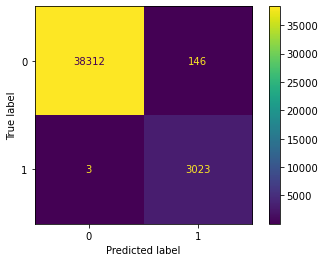

In [28]:
# Confusion matrix - training

cm = confusion_matrix(y_train, pred_tr, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

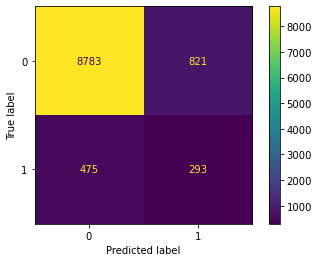

In [29]:
# Confusion matrix - testing

cm = confusion_matrix(y_test, pred_tst, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

### Classifier with Balanced Data and Added Features

In [30]:
# Get train-test-split

X = trans_emb.drop(['address', 'fraud_flag'], axis=1)
flag = trans_emb['fraud_flag']

x_train, x_test, y_train, y_test = train_test_split(X, flag, test_size=0.2, random_state=42)

In [31]:
# Balance Training Data

sm = SMOTE(random_state=42)

x_smote, y_smote = sm.fit_resample(x_train, y_train)

In [32]:
# Extreme Gradient Boosting (XGBoost)

# Instanciate Model
xgbc = XGBClassifier(random_state=42)

# Hyperparameters grid
xgb_grid = {'gamma': [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8],
            'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
            'max_depth': range(3,10),
            'n_estimators': range(50,100),
            'reg_alpha': [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8],
            'reg_lambda': [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8]}

# Set RandomisedSearch
xgb = RandomizedSearchCV(estimator=xgbc, param_distributions=xgb_grid, scoring='f1', random_state=42, cv=10)

# Fit RandomisedSearch to training data
xgb.fit(x_smote, y_smote)

# List best hyperparameters
print("Best estimator for XGBoost Classifier:\n", xgb.best_estimator_)

Best estimator for XGBoost Classifier:
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.4, reg_lambda=1.6, ...)


In [33]:
# Set Model
xgbc = XGBClassifier(gamma=0.4, learning_rate=0.6, max_depth=7, n_estimators=90, reg_alpha=0.4, reg_lambda=1.6,
                     random_state=42)
xgbc.fit(x_smote, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.4, reg_lambda=1.6, ...)

In [34]:
# Performance

pred_tr = xgbc.predict(x_train)
pred_tst = xgbc.predict(x_test)

print('Balanced Classifier with trans2vec hyperparameter embeddings with Added Features')
print(' ')
print('Scores for flag=1')
print('In-sample F1 score: ', f1_score(y_train, pred_tr))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst))
print('In-sample Recall score: ', recall_score(y_train, pred_tr))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst))
print(' ')
print('Overall Scores')
print('In-sample F1 score: ', f1_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample F1 score: ', f1_score(y_test, pred_tst, average='weighted'))
print('In-sample Recall score: ', recall_score(y_train, pred_tr, average='weighted'))
print('Out-of-sample Recall score: ', recall_score(y_test, pred_tst, average='weighted'))

Balanced Classifier with trans2vec hyperparameter embeddings with Added Features
 
Scores for flag=1
In-sample F1 score:  0.9811810512654121
Out-of-sample F1 score:  0.41271495570609695
In-sample Recall score:  0.9993390614672836
Out-of-sample Recall score:  0.515625
 
Overall Scores
In-sample F1 score:  0.9972271064073125
Out-of-sample F1 score:  0.9010798802149238
In-sample Recall score:  0.9972037412014271
Out-of-sample Recall score:  0.8913420748168145


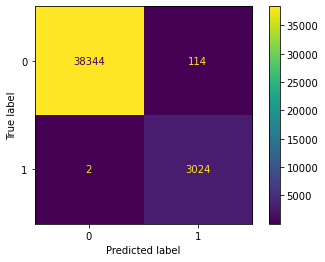

In [35]:
# Confusion matrix - training

cm = confusion_matrix(y_train, pred_tr, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

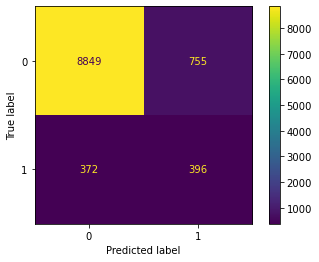

In [36]:
# Confusion matrix - testing

cm = confusion_matrix(y_test, pred_tst, labels=xgbc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgbc.classes_)
disp.plot()
plt.show()

In [37]:
# Assess Feature Importance

# Get feature importance in a dataframe
imp_xgb = pd.DataFrame(xgbc.feature_importances_/xgbc.feature_importances_.max(), index=x_train.columns, 
                       columns=['XGBoost Importance'])

# Display feature importance
imp_xgb = imp_xgb.sort_values('XGBoost Importance', ascending=False)
imp_xgb.head(30) # Report top 30 features only due to large amount of features

,XGBoost Importance
diff_fees,1.000000
inf_median,0.368966
18,0.280195
output_count,0.278325
outa_max,0.241268
30,0.234288
self_loop,0.204632
29,0.201569
40,0.173822
inf_total,0.170770


In [38]:
# Least Important
imp_xgb.tail(30)

,XGBoost Importance
62,0.058890
6,0.058723
21,0.058689
41,0.057092
56,0.055004
diff_amount,0.053813
44,0.052614
0,0.052088
43,0.050496
12,0.049557
